## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-tail4/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_1/'
fold_n = 1
# Unzip files
!tar -xvf /kaggle/input/jigsaw-data-split-roberta-192-ratio-2-clean-tail4/fold_1.tar.gz

Train samples: 398295


,comment_text,toxic,length,word_count,token_count,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,I agree give Clinton another shot in it s just...,0.0,161,29,34,0,train,validation,train,train,train
1,It s my understanding that BC has quietly advi...,0.0,137,28,34,0,train,train,validation,train,train
2,Bill we also have a policy called WP BOLD You ...,0.0,604,121,129,0,train,train,validation,train,train
3,He s absolutely right though Trudeau is sellin...,0.0,54,10,14,0,train,train,train,train,validation
4,eyesnore faggot of the year,1.0,27,5,10,1,train,train,validation,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


fold_1/
fold_1/x_valid_tail.npy
fold_1/y_valid_int_tail.npy
fold_1/x_train_tail.npy
fold_1/y_valid_int.npy
fold_1/y_train.npy
fold_1/y_valid.npy
fold_1/y_train_int.npy
fold_1/y_train_int_tail.npy
fold_1/y_valid_tail.npy
fold_1/x_train.npy
fold_1/y_train_tail.npy
fold_1/x_valid.npy


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 4,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

## Learning rate schedule

Learning rate schedule: 1e-07 to 9.79e-06 to 1.1e-06


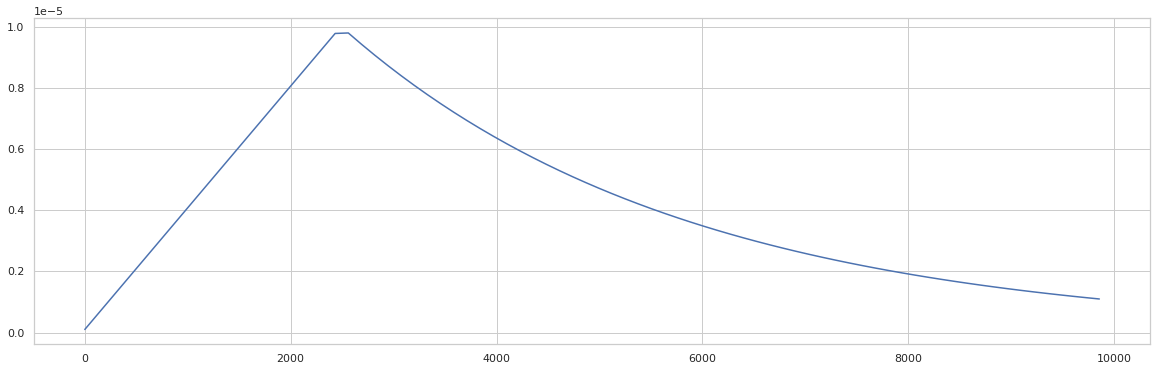

In [5]:
lr_min = 1e-7
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
step_size = len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 1
decay = .9997

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps, hold_max_steps, 
                                      lr_start, lr_max, lr_min, decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train_int.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train_tail = np.load(base_data_path + 'x_train_tail.npy')
y_train_tail = np.load(base_data_path + 'y_train_int_tail.npy').reshape(x_train_tail.shape[1], 1).astype(np.float32)
x_train = np.hstack([x_train, x_train_tail])
y_train = np.vstack([y_train, y_train_tail])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)

# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: 
                                exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                 warmup_steps, hold_max_steps, lr_start, 
                                                                 lr_max, lr_min, decay))
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()

metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc}

history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                     step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], 
                     config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
x_train = np.load(base_data_path + 'x_train.npy')
x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

k_fold.loc[k_fold[f'fold_{fold_n}'] == 'train', f'pred_{fold_n}'] = np.round(train_preds)
k_fold.loc[k_fold[f'fold_{fold_n}'] == 'validation', f'pred_{fold_n}'] = np.round(valid_preds)
valid_df[f'pred_{fold_n}'] = valid_ml_preds


# Fine-tune on validation set
#################### ADD TAIL ####################
x_valid_ml_tail = np.hstack([x_valid_ml, np.load(database_base_path + 'x_valid_tail.npy')])
y_valid_ml_tail = np.vstack([y_valid_ml, y_valid_ml])

valid_step_size_tail = x_valid_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_valid_ml_tail, y_valid_ml_tail, 
                                                                                 config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

history_ml = custom_fit(model, metrics_dict, train_step, valid_step, train_ml_data_iter, valid_data_iter, 
                        valid_step_size_tail, valid_step_size, config['BATCH_SIZE'], 1, 
                        config['ES_PATIENCE'], save_last=False)

# Join history
for key in history_ml.keys():
    history[key] += history_ml[key]
    
model.save_weights('model_ml.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df[f'pred_ml_{fold_n}'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 4978 steps, validate for 62 steps

EPOCH 1/4
time: 1706.3s loss: 0.2365 auc: 0.9613 val_loss: 0.2748 val_auc: 0.9159

EPOCH 2/4
time: 1509.8s loss: 0.1565 auc: 0.9827 val_loss: 0.3129 val_auc: 0.9093

EPOCH 3/4
time: 1509.8s loss: 0.1361 auc: 0.9867 val_loss: 0.3250 val_auc: 0.9031

EPOCH 4/4
time: 1509.8s loss: 0.1309 auc: 0.9876 val_loss: 0.3223 val_auc: 0.9044
Training finished
Train for 125 steps, validate for 62 steps

EPOCH 1/1
time: 1613.8s loss: 7.3475 auc: 0.9554 val_loss: 0.1182 val_auc: 0.9836
Training finished


## Model loss graph

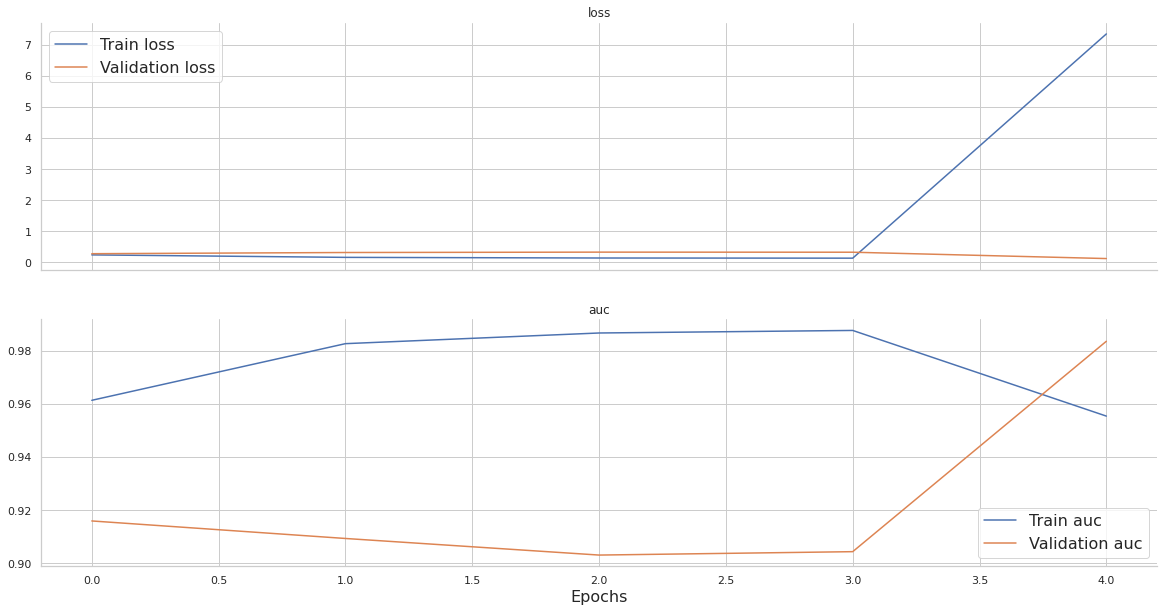

In [8]:
plot_metrics(history)

# Model evaluation

In [9]:
display(evaluate_model_single_fold(k_fold, fold_n, label_col='toxic_int').style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.955983,0.925805,0.030178,0.955983,0.925805
Accuracy,0.949447,0.921854,0.027593,0.949447,0.921854
Precision,0.884767,0.845184,0.039583,0.884767,0.845184
Recall,0.975654,0.937695,0.037959,0.975654,0.937695
F1-score,0.927990,0.889039,0.038951,0.927990,0.889039
Support,106382.000000,26595.000000,79787.000000,106382.000000,26595.000000


# Confusion matrix

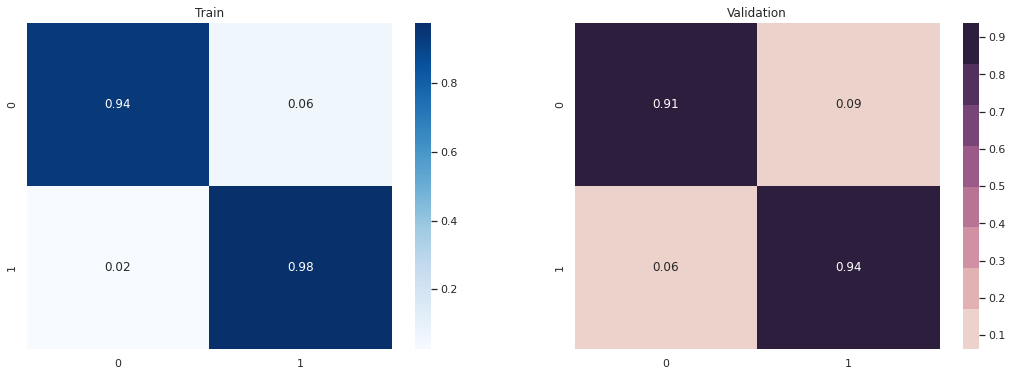

In [10]:
train_set = k_fold[k_fold[f'fold_{fold_n}'] == 'train']
validation_set = k_fold[k_fold[f'fold_{fold_n}'] == 'validation'] 
plot_confusion_matrix(train_set['toxic_int'], train_set[f'pred_{fold_n}'], 
                      validation_set['toxic_int'], validation_set[f'pred_{fold_n}'])

# Model evaluation by language

In [11]:
display(evaluate_model_single_fold_lang(valid_df, fold_n).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_single_fold_lang(valid_df, fold_n, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.919145,0.919145
es,0.900392,0.900392
it,0.878217,0.878217
tr,0.979418,0.979418


,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.982187,0.982187
es,0.976198,0.976198
it,0.968925,0.968925
tr,0.994720,0.994720


# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic,pred_1
0,I agree give Clinton another shot in it s just what the Democratic Party needs she could pick Nancy Pelosi as her ru...,0.000000,0.0
1,It s my understanding that BC has quietly advised Mr Kenney they are ready willing to build that wall he wants and t...,0.000000,0.0
2,Bill we also have a policy called WP BOLD You do not have to wait for any particular person to approve your edit bef...,0.000000,0.0
3,He s absolutely right though Trudeau is selling us out,0.000000,0.0
4,eyesnore faggot of the year,1.000000,1.0
5,I ll be signing the Stand for Salmon initiative and I ll be voting for it when it is placed on the ballot I ll even ...,0.000000,0.0
6,When did illegal immigrant become asylum seeker This country is a joke to the world We are nothing but a bunch of ch...,0.763158,1.0
7,Bitches be jealous,0.963095,1.0
8,I was a charter subscriber to First Things when it was only a newsletter and when Richard Neuhaus was still a Luther...,0.500000,0.0
9,I concur You d think they d have removed it by now Figure It Out All I ve ever seen on the network is Wild Style,0.000000,0.0


Multilingual validation set


,comment_text,toxic,pred_1,pred_ml_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.869806,0.585599
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.000107,0.004276
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.906900,0.841622
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.000070,0.000087
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.000151,0.000308
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.000627,0.014431
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.000014,0.000011
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.000333,0.000486
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.000626,0.000616
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.000062,0.000015


# Test set predictions

In [13]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [14]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,6.381200e+04
mean,31905.500000,2.200196e-01
std,18421.082026,3.354675e-01
min,0.000000,2.980232e-08
25%,15952.750000,2.051219e-04
50%,31905.500000,4.820481e-03
75%,47858.250000,3.731135e-01
max,63811.000000,9.999204e-01


,id,toxic
0,0,0.000061
1,1,0.000756
2,2,0.527198
3,3,0.000330
4,4,0.000791
5,5,0.002453
6,6,0.000239
7,7,0.000089
8,8,0.270606
9,9,0.263812
